# Count Gaia targets in bins of magnitude (in a circular patch)

In this particular example, start bin number zero at magnitude 3, and bins are 0.2 mag wide.

    select magnitude, count(*) as n 
        from ( 
            select to_integer(floor((phot_g_mean_mag - 3)/0.2)) as magnitude from gaiadr3.gaia_source
            where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',%.3f,%.3f,%.3f))
        )  as subquery    
    group by magnitude

In [5]:
## to query Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import QTable
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited

queryStringGaia = """select magnitude, count(*) as n 
    from ( 
        select to_integer(floor((phot_g_mean_mag - 3)/0.2)) as magnitude from gaiadr3.gaia_source
        where 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',%.3f,%.3f,%.3f))
    )  as subquery    
group by magnitude""" % (282.747,-6.28,0.3)

job = Gaia.launch_job_async(queryStringGaia,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


Text(0, 0.5, 'number of sources')

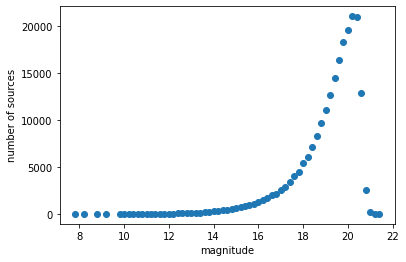

In [13]:
import matplotlib.pyplot as plt
plt.scatter( 3 + GaiaT['magnitude']/5. , GaiaT['n'] )
plt.xlabel('magnitude')
plt.ylabel('number of sources')

# Count k and n for subsets given a condition, in healpix regions

Divide by $2^{59 - 2n} = 562949953421312$ (with $n=5$) to know healpix number in level 5.

This is actually implemented now as: 
        
        GAIA_HEALPIX_INDEX(5, source_id)

    select magnitude, position, count(*) as n, sum(selection) as k
        from (
                select to_integer(floor((phot_g_mean_mag - 3)/0.2)) as magnitude,
                to_integer(floor(source_id/562949953421312)) as position,
                to_integer(IF_THEN_ELSE(parallax > -9999, 1.0,0.0)) as selection
            from gaiadr3.gaia_source 
            where phot_g_mean_mag > 3 and phot_g_mean_mag < 23
            and g_rp > -2.5 and g_rp < 5.1
        ) as subquery
    group by magnitude, position

# Count DR3 stars with gspspec metallicites

Uses a join on source_id

    SELECT count(*)
    FROM gaiadr3.gaia_source AS g
    INNER JOIN gaiadr3.astrophysical_parameters AS ap
    ON g.source_id = ap.source_id
    WHERE ap.mh_gspspec is not null

# Random subset of DR3 with gspspec metallicities

Uses a join and the random_index from gaia_source

    SELECT TOP 1000 g.ra,g.dec,g.parallax, ap.*
    FROM gaiadr3.gaia_source AS g
    INNER JOIN gaiadr3.astrophysical_parameters AS ap
    ON g.source_id = ap.source_id
    WHERE ap.mh_gspspec is not null
    ORDER by g.random_index

# Cone search

    SELECT * from gaiadr3.gaia_source_lite
    WHERE ( 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',189.9,-60.65,0.2)) ) 

# XP data in a cone

Using inner join

    SELECT dr3.*, xp.*
    FROM gaiadr3.xp_summary AS xp
    INNER JOIN gaiadr3.gaia_source_lite AS dr3
        ON dr3.source_id = xp.source_id
    WHERE ( 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',189.9,-60.65,0.2)) ) 

# Grab calibrated XP spectra (here in a cone for Trumpler 20)

Will use astroquery and make an authenticated query.

**calibrate()** can take a query string, or a list of source_id.

If no sampling is given, the default sampling is returned. The default sampling is generated internally and it corresponds to numpy.arange(336., 1021., 2.) in absolute wavelengths [nm].

In [14]:
# Import the tool
from gaiaxpy import calibrate

In [15]:
query_input = """select TOP 100 source_id from gaiadr3.gaia_source 
WHERE ( 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',189.9,-60.65,0.2)) ) and has_xp_continuous = 't'"""
calibrated_spectra, sampling = calibrate(query_input)
calibrated_spectra

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: tcantatg
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK
INFO: Query finished. [astroquery.utils.tap.core]


,source_id,flux,flux_error
0,6056505839960824192,"[9.215457511652099e-17, 6.630790091967434e-17,...","[3.3445215242952265e-17, 2.4449899558072116e-1..."
1,6056505839960824320,"[3.0012041948815264e-18, 2.792076229576887e-18...","[2.4323957610545294e-18, 1.6791992532993105e-1..."
2,6056505839960824704,"[2.728232727285602e-18, 1.5578148295045203e-18...","[2.389531914471701e-18, 1.668376476618204e-18,..."
3,6056507764106673920,"[1.3881151500624388e-18, 2.0509279408937373e-1...","[2.260179984795938e-18, 1.620814879502917e-18,..."
4,6056507764106675968,"[3.5472314467009796e-18, 2.7831008738639475e-1...","[2.50319022689261e-18, 1.7689467364290165e-18,..."
...,...,...,...
95,6056509241575455616,"[1.696524923512542e-17, 1.1652498295884343e-17...","[4.350308956701723e-18, 3.2460619760415225e-18..."
96,6056509241575609728,"[2.4175326134158993e-18, -2.1238383912709689e-...","[2.7374078919866054e-18, 1.9589988556321506e-1..."
97,6056509271595560576,"[1.3323702280976493e-18, 7.641779739463075e-19...","[2.224906565876349e-18, 1.561315898429468e-18,..."
98,6056509271595570432,"[-5.8946086550927825e-18, -4.808653951914141e-...","[2.387839363196205e-18, 1.6865213035030465e-18..."


Also grab more data for these stars from the gaia_source table:

In [16]:
## to query Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.table import QTable
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = -1 #default is 50 rows max, -1 for unlimited

queryStringGaia = """SELECT ra, dec, l, b, phot_g_mean_mag, bp_rp, pmra, pmdec, source_id
    FROM gaiadr3.gaia_source 
    WHERE ( 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',189.9,-60.65,0.1)) ) and has_xp_continuous = 't'"""
job = Gaia.launch_job_async(queryStringGaia,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


Filter on proper motions, keep the list of source_id of the retained stars, call **calibrate()** on that list to query the archive again and grab the calibrated spectra for that particular subset:

In [17]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
distPM = np.sqrt(  (GaiaT['pmra']+7.10)**2 + (GaiaT['pmdec']-0.2)**2 )
keep = np.array([True for foo in GaiaT])
keep[distPM>0.3]=False

calibrated_spectra, sampling = calibrate( [s for s in GaiaT['source_id'][keep]] )

INFO: Login to gaia TAP server [astroquery.gaia.core]
User: tcantatg
Password: ········
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


Plot. gaiaxpy has its own plotting function that also displays the flux error, but is less flexible.

Text(0, 0.5, 'flux')

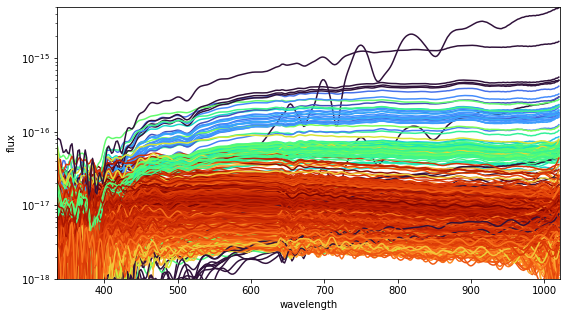

In [19]:
cmap = matplotlib.cm.get_cmap('turbo_r')
vmin = 0.95
vmax = 2.0
a = 1./(vmax-vmin)
b = 1 - vmax/(vmax-vmin)

plt.figure(figsize=(9,5))
for i in range(len(GaiaT['source_id'][keep])):
    colorToPlot = GaiaT['bp_rp'][ GaiaT['source_id']==GaiaT['source_id'][keep][i] ]
    #print(float(colorToPlot))
    plt.plot( sampling ,calibrated_spectra['flux'][i] , c=cmap(a*colorToPlot+b))
plt.ylim(1e-18,5e-15)
plt.yscale('log')
plt.xlim(336,1021)
plt.xlabel('wavelength')
plt.ylabel('flux')

# Gaia x 2MASS using the official xmatch table

Performing a cross match for 2MASS requires one more extra step because of how IDs are listed for point sources and extended sources separately.

This example shows how to get **some** Gaia DR3 and **all** of the 2MASS columns around the cluster Berkeley 64:

    
    SELECT gaia.source_id, gaia.ra, gaia.dec, gaia.parallax, gaia.pmra, gaia.pmdec, tmass.*
    FROM gaiadr3.gaia_source AS gaia
    JOIN gaiadr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
    JOIN gaiadr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
    JOIN gaiadr1.tmass_original_valid AS tmass ON
       xjoin.original_psc_source_id = tmass.designation
    WHERE ( 1=CONTAINS(POINT('ICRS',gaia.l,gaia.b),CIRCLE('ICRS',131.919,4.605,0.25)) )

# De-reddened CMD, do binning on archive directly

Here we impose `random_index < 500000` to keep the query time shorter.

In [66]:
%%time
query_string = '''
SELECT bp_rp_index / 40 AS bp_rp, g_abs_index / 10 AS g_abs, n
FROM (
  SELECT 
      FLOOR((bp_rp - ebpminrp_gspphot) * 40) AS bp_rp_index, 
      FLOOR((phot_g_mean_mag - ag_gspphot + 5 * LOG10(parallax) - 10) * 10) AS g_abs_index, 
      COUNT(*) AS n
  FROM gaiadr3.gaia_source
  WHERE parallax_over_error > 5
  AND ag_gspphot IS NOT NULL
  AND random_index < 500000
  GROUP BY bp_rp_index, g_abs_index
) AS subquery'''
job = Gaia.launch_job_async(query_string,
                    dump_to_file=False, output_format='votable')
GaiaT = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 273 ms, sys: 13.6 ms, total: 286 ms
Wall time: 2.85 s


Text(0, 0.5, 'Gabs')

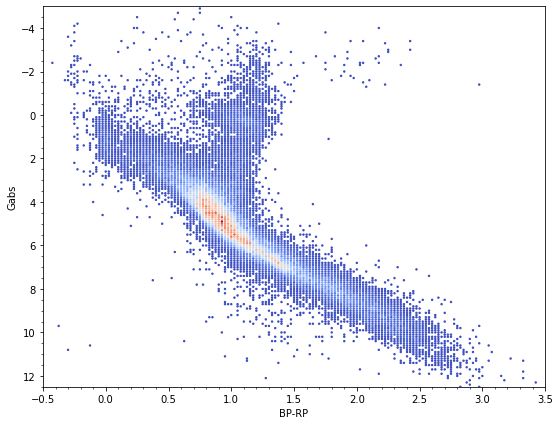

In [67]:
plt.figure(figsize=(9,7))
plt.scatter( GaiaT['bp_rp'] , GaiaT['g_abs'] , c=GaiaT['n'] , s=2 , cmap='coolwarm')
plt.ylim(12.5,-5); plt.xlim(-0.5,3.5); plt.minorticks_on()
plt.xlabel('BP-RP'); plt.ylabel('Gabs')

# Add Gaia columns to table

Works if the table has a **source_id** column.

Uses astroquery to upload an intermediate table (which only contains the source_id list).

In [78]:
import pandas as pd

example_source_ids = pd.DataFrame([6056505839960824192,
6056505839960824320,
6056505839960824704,
6056507764106673920,
6056507764106675968],columns = ['source_id'])

def fill_in_gaia(someDf,colnames):
    """Uploads the list of source_id from the df.
    Queries the requested columns with that source_id.
    Grabs the result.
    In the df, replaces the columns with those from result.
    
    Also works with an astropy Table.
    """
    from astroquery.gaia import Gaia
    from astropy.table import Table

    try:
        t = Table.from_pandas( someDf[['source_id']] )
    except: #if can't convert from pandas, try as astropy Table
        t = someDf[['source_id']]
    t.write('temp.vot',format='votable',overwrite=True)
    print('Written intermediate file temp.vot')
    
    cols = ', '.join(['dr3.'+c for c in colnames])
    queryString = """SELECT dr3.source_id, %s 
    FROM gaiadr3.gaia_source AS dr3 
    JOIN tap_upload.temp_table_ids AS t 
    ON dr3.source_id = t.source_id""" % (cols)
    Gaia.ROW_LIMIT = -1
    j = Gaia.launch_job_async(query=queryString,
                        upload_resource='temp.vot', upload_table_name="temp_table_ids", verbose=True)
    r = j.get_results()
    
    oDf = someDf.copy()
    for c in colnames:
        oDf[c] = r[c]
    return oDf

newDf = fill_in_gaia(example_source_ids,['parallax','parallax_error','pmra','pmra_error',
                         'pmdec','pmdec_error','random_index','ref_epoch',
                         'ra_error','dec_error','parallax_over_error','pm',
                        'pseudocolour','astrometric_matched_transits','visibility_periods_used',
                        'matched_transits','ruwe','phot_g_n_obs','phot_g_mean_mag','phot_bp_n_obs',
                         'phot_bp_mean_mag','phot_rp_n_obs','phot_rp_mean_mag','bp_rp','bp_g',
                         'g_rp','l','b','ecl_lon','ecl_lat','radial_velocity','radial_velocity_error',
                         'vbroad','vbroad_error'])

newDf

Written intermediate file temp.vot
Launched query: 'SELECT dr3.source_id, dr3.parallax, dr3.parallax_error, dr3.pmra, dr3.pmra_error, dr3.pmdec, dr3.pmdec_error, dr3.random_index, dr3.ref_epoch, dr3.ra_error, dr3.dec_error, dr3.parallax_over_error, dr3.pm, dr3.pseudocolour, dr3.astrometric_matched_transits, dr3.visibility_periods_used, dr3.matched_transits, dr3.ruwe, dr3.phot_g_n_obs, dr3.phot_g_mean_mag, dr3.phot_bp_n_obs, dr3.phot_bp_mean_mag, dr3.phot_rp_n_obs, dr3.phot_rp_mean_mag, dr3.bp_rp, dr3.bp_g, dr3.g_rp, dr3.l, dr3.b, dr3.ecl_lon, dr3.ecl_lat, dr3.radial_velocity, dr3.radial_velocity_error, dr3.vbroad, dr3.vbroad_error 
    FROM gaiadr3.gaia_source AS dr3 
    JOIN tap_upload.temp_table_ids AS t 
    ON dr3.source_id = t.source_id'
------>https
host = gea.esac.esa.int:443
context = /tap-server/tap/async
Content-type = multipart/form-data; boundary====1678782535630===
303 303
[('Date', 'Tue, 14 Mar 2023 08:28:55 GMT'), ('Server', 'Apache/2.4.6 (CentOS) OpenSSL/1.0.2k-fips mo

,source_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,random_index,ref_epoch,ra_error,...,bp_g,g_rp,l,b,ecl_lon,ecl_lat,radial_velocity,radial_velocity_error,vbroad,vbroad_error
0,6056505839960824192,0.362956,0.022700,-6.320477,0.021207,-0.894442,0.023977,802351897,2016.0,0.015733,...,2.005527,1.311755,301.382538,2.014446,221.319568,-50.212255,6.212149,0.27692,NaN,NaN
1,6056505839960824320,0.366460,0.065448,-5.699534,0.064973,1.366518,0.064609,300156524,2016.0,0.045822,...,0.692133,0.891388,301.380317,2.015522,221.315762,-50.212645,NaN,NaN,NaN,NaN
2,6056505839960824704,0.127152,0.050000,-6.383352,0.045217,-0.338358,0.049205,35175451,2016.0,0.034377,...,1.559509,1.246878,301.382706,2.017664,221.316901,-50.209521,NaN,NaN,NaN,NaN
3,6056507764106673920,0.415283,0.065990,-5.986850,0.058313,-0.221664,0.064316,1607288173,2016.0,0.044919,...,0.640572,0.747843,301.514762,1.991532,221.509089,-50.155161,NaN,NaN,NaN,NaN
4,6056507764106675968,0.045284,0.046316,-5.555190,0.040213,-0.319905,0.045605,596356169,2016.0,0.031785,...,1.560682,1.210111,301.513832,1.993174,221.506428,-50.154352,NaN,NaN,NaN,NaN


# Query GAVO data

2023-03-13: GAVO seems to return VO tables that are not compliant with astropy (error E09, although they are readable by Topcat) so we must specify **responseformat='fits'** when submitting the job. The built-in pyvo method **fetch_result()** seems to expect a VO table, so we have to manually grab the results with **Table.read(...)**.

In [139]:
import time
import pyvo as vo
from astropy.table import Table

gavo_query_string = """SELECT top 5 g.source_id, g.ra, g.dec, g.parallax, 
g.radial_velocity, g.radial_velocity_error, bj.r_med_geo 
FROM gaia.dr3lite AS g, gedr3dist.main AS bj 
WHERE g.source_id = bj.source_id and g.radial_velocity<100000 
ORDER BY g.random_index"""

async_srv = vo.dal.TAPService("https://dc.zah.uni-heidelberg.de/__system__/tap/run")
job = async_srv.submit_job(gavo_query_string,
                           responseformat='fits',maxrec=100000)
job.run()  

while job.phase == 'EXECUTING':
    time.sleep(1)
    

r = Table.read(job.url+'/results/result')
print(r)

     source_id              ra         ... radial_velocity_error r_med_geo
                           deg         ...         km / s            pc   
------------------- ------------------ ... --------------------- ---------
4040949706019490560 265.22936348434496 ...             2.2890708  2482.239
1823532754729083392 300.80580445460237 ...              5.852169 1089.1147
3586362911238437248 171.80987737943448 ...             3.1172297 138.30095
6068055453656132736  198.6858034678276 ...              2.958417  718.4024
4067121033299563392  265.9204358611912 ...               5.68035  9628.693


SELECT top 1000000 g.source_id, g.ra, g.dec, g.parallax, g.radial_velocity, g.radial_velocity_error, bj.r_med_geo FROM gaia.dr3lite AS g, gedr3dist.main AS bj WHERE g.source_id = bj.source_id and g.radial_velocity<100000 order by g.random_index

# Get some Gaia data, add columns from GAVO

Upload to GAVO doesn't seem to be possible. We can hard-code OR conditions on a list of source_ids.

10K sources: 8min for Gaia. 100K: 6min! or 12... 1M: 5/3min

100 sources: 5s at GAVO. 1000: 10s. 10,000: 1 minute. 100,000: 10 minutes. I haven't tried longer, but it looks like 10 chunks for 100,000 would take the same time as a single batch of 1 million. (divide these numbers by 2 if parsing list of source_ids instead of parsing ORs) With the list trick, 1M sources at GAVO is too many.

Querying GAVO with ten parallel queries of 10K each takes: forever. Actually we can only have two queries at once, additional queries get queued.

The example here has four cells. The first one queries the Gaia data. The other three all do the same thing but in three different ways: grab sources by source_id using OR conditions, or parsing a list, or as multiple queries of 100K sources each.

In [201]:
%%time
# Gaia data:
from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1
queryString="""SELECT TOP 100000 g.source_id, g.ra,g.dec,g.parallax, ap.mh_gspspec
FROM gaiadr3.gaia_source AS g
INNER JOIN gaiadr3.astrophysical_parameters AS ap
ON g.source_id = ap.source_id
WHERE ap.mh_gspspec is not null
ORDER by g.random_index"""
j = Gaia.launch_job_async(query=queryString, verbose=False)
rGaia = j.get_results()

INFO: Query finished. [astroquery.utils.tap.core]
CPU times: user 28.3 s, sys: 1.71 s, total: 30 s
Wall time: 12min 12s


In [202]:
%%time
# Faster way to do the exact same thing: parse a list of source_id
gavo_query_string = """SELECT g.source_id, bj.r_med_geo 
FROM gaia.dr3lite AS g, gedr3dist.main AS bj 
WHERE g.source_id = bj.source_id AND bj.source_id in ('""" + "','".join([str(sss) for sss in rGaia['source_id']]) + "')"

async_srv = vo.dal.TAPService("https://dc.zah.uni-heidelberg.de/__system__/tap/run")
job = async_srv.submit_job(gavo_query_string,
                           responseformat='fits',maxrec=1000000)
job.run()  

while job.phase == 'EXECUTING':
    time.sleep(1)
    

rGAVO = Table.read(job.url+'/results/result')
print(len(rGAVO),'rows in the result table.')

99722 rows in the result table.
CPU times: user 24.5 s, sys: 7.27 s, total: 31.8 s
Wall time: 5min 18s


In [ ]:
%%time
# SPLITTING QUERIES
a = rGaia['source_id']
n = 5000

allChunkResults = []

for ichunk,chunk in enumerate([ a[i:i+n] for i in range(len(a)) if i%n==0 ]):
    print('Doing chunk number',ichunk)
    gavo_query_string = """SELECT g.source_id, bj.r_med_geo 
    FROM gaia.dr3lite AS g, gedr3dist.main AS bj 
    WHERE g.source_id = bj.source_id AND bj.source_id in ('""" + "','".join([str(sss) for sss in rGaia['source_id']]) + "')"

    async_srv = vo.dal.TAPService("https://dc.zah.uni-heidelberg.de/__system__/tap/run")
    job = async_srv.submit_job(gavo_query_string,
                               responseformat='fits',maxrec=100000)
    job.run()  

    while job.phase == 'EXECUTING':
        time.sleep(1)

    rGAVOchunk = Table.read(job.url+'/results/result')
    allChunkResults.append(rGAVOchunk)

# Gradient sample from DR3 PVP

https://ui.adsabs.harvard.edu/abs/2022arXiv220605534G/abstract

% is equivalent to the * wildcard (0 or 1 or more characters)

_ represents one single character

**e.g.** WHERE CustomerName LIKE 'a_%'	Finds any values that start with "a" and are at least 2 characters in length

    SELECT g.ra,g.dec, g.source_id, g.phot_g_mean_mag, g.phot_bp_mean_mag, g.phot_rp_mean_mag, g.parallax,
    g.bp_rp, g.parallax_error, g.radial_velocity, g.radial_velocity_error,  aux.teff_gspspec,
     aux.teff_gspspec_lower,
     aux.teff_gspspec_upper,
     aux.logg_gspspec,
     aux.logg_gspspec_lower,
     aux.logg_gspspec_upper,
     aux.mh_gspspec,
     aux.mh_gspspec_lower,
     aux.mh_gspspec_upper,
     aux.alphafe_gspspec,
     aux.alphafe_gspspec_lower,
     aux.alphafe_gspspec_upper

    FROM gaiadr3.gaia_source as g INNER JOIN (
    SELECT source_id,  teff_gspspec,
     teff_gspspec_lower,
     teff_gspspec_upper,
     logg_gspspec,
     logg_gspspec_lower,
     logg_gspspec_upper,
     mh_gspspec,
     mh_gspspec_lower,
     mh_gspspec_upper,
     alphafe_gspspec,
     alphafe_gspspec_lower,
     alphafe_gspspec_upper,
    FROM gaiadr3.astrophysical_parameters as ap
    WHERE ((ap.flags_gspspec LIKE '0%') OR (ap.flags_gspspec
    LIKE '1%')) AND ((ap.flags_gspspec LIKE '_0%') OR
    (ap.flags_gspspec LIKE '_1%')) AND ((ap.flags_gspspec
    LIKE '__0%') OR (ap.flags_gspspec LIKE '__1%')) AND
    ((ap.flags_gspspec LIKE '___0%') OR (ap.flags_gspspec
    LIKE '___1%')) AND ((ap.flags_gspspec LIKE
    '____0%') OR (ap.flags_gspspec LIKE '____1%')) AND
    ((ap.flags_gspspec LIKE '_____0%') OR
    (ap.flags_gspspec LIKE '_____1%')) AND
    ((ap.flags_gspspec LIKE '______0%') OR
    (ap.flags_gspspec LIKE '______1%')) AND
    (ap.flags_gspspec LIKE '_______0%') AND
    (ap.flags_gspspec LIKE '________0%') AND
    (ap.flags_gspspec LIKE '_________0%') AND
    (ap.flags_gspspec LIKE '__________0%') AND
    (ap.flags_gspspec LIKE '___________0%') AND
    (ap.flags_gspspec LIKE '____________0%') AND
    (ap.teff_gspspec>4000) ) as aux USING (source_id)
    WHERE(g.ruwe<=1.4)

# Positional cross-match by repeating small cone queries

Here grabbing Gaia DR3 values for stars around the position of APOGEE DR17 sources.

In [ ]:
%%time
from astropy.table import Table
tApogee_ok = Table.read('apogee_lite_valid_sf_withRCparams_andTing18.fits')
tApogee_ok['source_id'] = tApogee_ok['GAIAEDR3_SOURCE_ID']


from astroquery.gaia import Gaia
Gaia.ROW_LIMIT = -1

# Keep only RA and DEC
t = tApogee_ok[['RA','DEC','GAIAEDR3_SOURCE_ID','GAIAEDR3_PHOT_G_MEAN_MAG','GAIAEDR3_PARALLAX']]
t.write('tempradec.vot',format='votable',overwrite=True)


queryString = """SELECT gaia.ra, gaia.dec, gaia.source_id, gaia.phot_g_mean_mag,
gaia.parallax,
gaia.nu_eff_used_in_astrometry, gaia.pseudocolour, gaia.ecl_lat, 
gaia.astrometric_params_solved, t.GAIAEDR3_SOURCE_ID, t.GAIAEDR3_PHOT_G_MEAN_MAG,
t.GAIAEDR3_PARALLAX,
DISTANCE(
    POINT(t.RA, t.DEC),
    POINT(gaia.ra, gaia.dec)
) * 3600. AS dist_arcsec
FROM tap_upload.temp_table_radec AS t
JOIN gaiadr3.gaia_source AS gaia
-- Geometric Cross-Match: =======
ON 1 = CONTAINS(
    POINT(t.RA, t.DEC),
    CIRCLE(gaia.ra, gaia.dec, 3. / 3600.))""" 

j = Gaia.launch_job_async(query=queryString,
                    upload_resource='tempradec.vot', upload_table_name="temp_table_radec", verbose=True)
r = j.get_results()